# CSCI4022 Homework 9; Matrices


## Due Wednesday, December 8 at 11:59 pm to Canvas and Gradescope

#### Submit this file as a .ipynb with *all cells compiled and run* to the associated dropbox.

***

Your solutions to computational questions should include any specified Python code and results as well as written commentary on your conclusions.  Remember that you are encouraged to discuss the problems with your classmates, but **you must write all code and solutions on your own**.

**NOTES**: 

- Any relevant data sets should be available on Canvas. To make life easier on the graders if they need to run your code, do not change the relative path names here. Instead, move the files around on your computer.
- If you're not familiar with typesetting math directly into Markdown then by all means, do your work on paper first and then typeset it later.  Here is a [reference guide](https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference) linked on Canvas on writing math in Markdown. **All** of your written commentary, justifications and mathematical work should be in Markdown.  I also recommend the [wikibook](https://en.wikibooks.org/wiki/LaTeX) for LaTex.
- Because you can technically evaluate notebook cells is a non-linear order, it's a good idea to do **Kernel $\rightarrow$ Restart & Run All** as a check before submitting your solutions.  That way if we need to run your code you will know that it will work as expected. 
- It is **bad form** to make your reader interpret numerical output from your code.  If a question asks you to compute some value from the data you should show your code output **AND** write a summary of the results in Markdown directly below your code. 
- 45 points of this assignment are in problems.  The remaining 5 are for neatness, style, and overall exposition of both code and text.
- This probably goes without saying, but... For any question that asks you to calculate something, you **must show all work and justify your answers to receive credit**. Sparse or nonexistent work will receive sparse or nonexistent credit. 
- There is *not a prescribed API* for these problems.  You may answer coding questions with whatever syntax or object typing you deem fit.  Your evaluation will primarily live in the clarity of how well you present your final results, so don't skip over any interpretations!  Your code should still be commented and readable to ensure you followed the given course algorithm.

---
**Shortcuts:**  [Problem 1](#p1) | [Problem 2](#p2) | 
---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import timeit
from sklearn.ensemble import IsolationForest

***
<a/ id='p1'></a>
[Back to top](#top)
# Problem 1 (20 pts; Practice: Outliers)

The file `nba2021pg.txt` includes all of the major basketball statistics from the 2020-2021 NBA season.  We're going to use it to determine whether "outlierness" of players correlated with their value to the team.  Load in the file and inspect it.

In [2]:
df=pd.read_csv('nba2021pg.txt')
df.head(8)

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Precious Achiuwa\achiupr01,PF,21,MIA,61,4,737,6.1,11.1,...,0.509,3.6,6.6,10.2,1.4,1.0,1.4,2.1,4.4,14.8
1,2,Jaylen Adams\adamsja01,PG,24,MIL,7,0,18,2.0,16.0,...,NaN,0.0,6.0,6.0,4.0,0.0,0.0,0.0,2.0,4.0
2,3,Steven Adams\adamsst01,C,27,NOP,58,58,1605,4.2,6.9,...,0.444,4.8,6.8,11.5,2.5,1.2,0.9,1.7,2.5,9.8
3,4,Bam Adebayo\adebaba01,C,23,MIA,64,64,2143,7.7,13.4,...,0.799,2.4,7.2,9.6,5.8,1.3,1.1,2.8,2.4,20.1
4,5,LaMarcus Aldridge\aldrila01,C,35,TOT,26,23,674,7.5,15.8,...,0.872,1.0,5.3,6.3,2.6,0.6,1.5,1.4,2.5,18.8
5,5,LaMarcus Aldridge\aldrila01,C,35,SAS,21,18,544,7.6,16.4,...,0.838,1.1,5.1,6.2,2.4,0.5,1.2,1.3,2.4,19.1
6,5,LaMarcus Aldridge\aldrila01,C,35,BRK,5,5,130,6.9,13.3,...,1.000,0.6,6.1,6.6,3.6,0.8,3.0,1.9,3.0,17.7
7,6,Ty-Shon Alexander\alexaty01,SG,22,PHO,15,0,47,2.3,9.2,...,0.500,1.5,6.1,7.7,4.6,0.0,0.8,2.3,1.5,6.9


In [3]:
df.columns

Index(['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

### Part A: Processing

Note that the data set creates **3** rows if a player played for 2 teams during the season: one for each team and a "Total."  For (only) those players, modify the data frame and delete all rows **except** when "Tm"="TOT" so each row becomes a unique player.

For all future plots, you may also only use NBA players that played at least 1000 minutes `MP` (around 1/4 of the seasons' total).

In [4]:
def counter(l):
    d = {}
    for item in l:
        if item not in d.keys():
            d[item] = 0
        d[item] += 1
    return d

def remove_duplicate_players(df):
    counts = counter(df.Player)
    for player in df.Player.unique():
        if counts[player] > 1:
            for i in df[df.Player == player].index:
                if df.loc[[i]].Tm.item() != 'TOT':
                    df = df.drop(i)
    return df

In [5]:
# Removes players who played for multiple teams, and only keeps their totals
df_unique        = remove_duplicate_players(df)

# Removes players who played less than 1000 minutes
minTimePlayed    = 1000
df_minTimePlayed = df_unique[df_unique.MP >= minTimePlayed]

# The filtered dataframe
df_filtered      = df_minTimePlayed
df_filtered.head(8)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: `item` has been deprecated and will be removed in a future version
  


,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
2,3,Steven Adams\adamsst01,C,27,NOP,58,58,1605,4.2,6.9,...,0.444,4.8,6.8,11.5,2.5,1.2,0.9,1.7,2.5,9.8
3,4,Bam Adebayo\adebaba01,C,23,MIA,64,64,2143,7.7,13.4,...,0.799,2.4,7.2,9.6,5.8,1.3,1.1,2.8,2.4,20.1
8,7,Nickeil Alexander-Walker\alexani01,SG,22,NOP,46,13,1007,6.9,16.4,...,0.727,0.5,4.7,5.1,3.6,1.7,0.8,2.5,3.1,18.2
9,8,Grayson Allen\allengr01,SG,25,MEM,50,38,1259,4.9,11.8,...,0.868,0.5,4.0,4.6,3.1,1.3,0.2,1.4,2.0,15.2
10,9,Jarrett Allen\allenja01,C,22,TOT,63,45,1864,5.8,9.3,...,0.703,3.8,8.4,12.2,2.0,0.6,1.7,1.9,1.9,15.6
16,11,Kyle Anderson\anderky01,PF,27,MEM,69,69,1887,5.9,12.6,...,0.783,1.0,6.6,7.6,4.8,1.6,1.1,1.6,2.3,16.3
17,12,Giannis Antetokounmpo\antetgi01,PF,26,MIL,61,61,2013,11.2,19.7,...,0.685,1.7,10.3,12.0,6.4,1.3,1.3,3.7,3.0,30.7
20,15,Carmelo Anthony\anthoca01,PF,36,POR,69,3,1690,7.0,16.6,...,0.890,0.7,3.9,4.6,2.2,1.0,0.8,1.3,3.1,19.7


### Part B: Outliers: Classical

Bi)  In the older days of NBA statistics, the most common measure of a players' value were in the triple (Points per game, Rebounds per game, Assists per game).  Create new columns in your data frame that house these 3 values.

Bii) Use your new columns in an $n \times 3$ object and calculate the **Mahalanobis' distance** for each player.  Who are the largest 10 outliers?

Biii) Use the `decision_function` method from a fit of SKLearn's `IsolationForest` library in the import statement above.  Who are the largest 10 outliers under an Isolation Forest?


In [6]:
def mahalanobis_distance(x, M):
    x_minus_mu  = x - np.mean(M)
    cov         = np.cov(M.T)
    inverse_cov = np.linalg.inv(cov)
    return x_minus_mu.T @ inverse_cov @ x_minus_mu

In [7]:
# i 
'''Just creates a dataframe with Points, Assists, and Total Rebounds'''
triple_columns = df_filtered[['PTS', 'AST', 'TRB']]
print(triple_columns.head(10), '\n') # SANITY CHECK

# ii
col_name = 'Mahalanobis'
n = 10

'''This part simply computes the Mahalanobis distance for each row'''
m_df = pd.DataFrame(columns=[col_name])
for i in triple_columns.index:
    m_df.loc[i] = mahalanobis_distance(triple_columns.loc[i], triple_columns)
# print(m_df.head(5), '\n') # SANITY CHECK
    
'''This part simply prints out the 'n' players with the largest sorted the Mahalanobis distances'''
print(f'Top {n} outliers based on Mahalanobis distance using the triple (PTS, AST, TRB)')
for rank, i in enumerate(m_df.sort_values(by=[col_name], ascending=False)[:n].index):
    print(f'{rank+1}. {df_filtered.loc[i].Player}')

# iii
col_name = 'iF Score'
scores = IsolationForest().fit(triple_columns).decision_function(triple_columns)
iF_df = pd.DataFrame(columns=[col_name])
for i, index in enumerate(triple_columns.index):
    iF_df.loc[index] = scores[i]
# print('\n', iF_df.head(5), '\n') # SANITY CHECK

'''This part simply prints out the 'n' players with the smallest sorted the Isolation Forest scores'''
print(f'\nTop {n} outliers based on an Isolation Forest using the triple (PTS, AST, TRB)')
for rank, i in enumerate(iF_df.sort_values(by=[col_name])[:n].index):
    print(f'{rank+1}. {df_filtered.loc[i].Player}')

     PTS  AST   TRB
2    9.8  2.5  11.5
3   20.1  5.8   9.6
8   18.2  3.6   5.1
9   15.2  3.1   4.6
10  15.6  2.0  12.2
16  16.3  4.8   7.6
17  30.7  6.4  12.0
20  19.7  2.2   4.6
21  17.1  5.4   6.2
22  17.1  2.4   6.0 

Top 10 outliers based on Mahalanobis distance using the triple (PTS, AST, TRB)
1. Draymond Green\greendr01
2. Russell Westbrook\westbru01
3. Dwight Howard\howardw01
4. Clint Capela\capelca01
5. Joel Embiid\embiijo01
6. Enes Kanter\kanteen01
7. James Harden\hardeja01
8. Jonas Valančiūnas\valanjo01
9. T.J. McConnell\mccontj01
10. Andre Drummond\drumman01

Top 10 outliers based on an Isolation Forest using the triple (PTS, AST, TRB)
1. Russell Westbrook\westbru01
2. Draymond Green\greendr01
3. Joel Embiid\embiijo01
4. Clint Capela\capelca01
5. Trae Young\youngtr01
6. Nikola Jokić\jokicni01
7. Giannis Antetokounmpo\antetgi01
8. Stephen Curry\curryst01
9. James Harden\hardeja01
10. Dwight Howard\howardw01


### Part C: Outliers: Rate

Ci)  These days, we often get better date that measures how effective or ineffective a player is *when they're on the court*.  These are known as *rate* statistics, and require us create "per minute" statistics for each player.  Create new columns that are (Points per 36 minutes, Rebounds per 36 minutes, Assists per 36 minutes) for each player.

Cii) Use your new columns in an $n \times 3$ object and calculate the **Mahalanobis' distance** for each player.  Who are the largest 10 outliers?

Ciii) Use the `decision_function` method from a fit of SKLearn's `IsolationForest` library in the import statement above.  Who are the largest 10 outliers under an Isolation Forest?


In [8]:
# i 
'''Just creates a dataframe with Points, Assists, and Total Rebounds'''
print(df_filtered.MP)
triple_columns /= df_filtered.MP
print(triple_columns.head(10), '\n') # SANITY CHECK

# # ii
# col_name = 'Mahalanobis'
# n = 10
# 
# '''This part simply computes the Mahalanobis distance for each row'''
# m_df = pd.DataFrame(columns=[col_name])
# for i in triple_columns.index:
#     m_df.loc[i] = mahalanobis_distance(triple_columns.loc[i], triple_columns)
# # print(m_df.head(5), '\n') # SANITY CHECK
#     
# '''This part simply prints out the 'n' players with the largest sorted the Mahalanobis distances'''
# print(f'Top {n} outliers based on Mahalanobis distance using the triple (PTS, AST, TRB)')
# for rank, i in enumerate(m_df.sort_values(by=[col_name], ascending=False)[:n].index):
#     print(f'{rank+1}. {df_filtered.loc[i].Player}')
# 
# # iii
# col_name = 'iF Score'
# scores = IsolationForest().fit(triple_columns).decision_function(triple_columns)
# iF_df = pd.DataFrame(columns=[col_name])
# for i, index in enumerate(triple_columns.index):
#     iF_df.loc[index] = scores[i]
# # print('\n', iF_df.head(5), '\n') # SANITY CHECK
# 
# '''This part simply prints out the 'n' players with the smallest sorted the Isolation Forest scores'''
# print(f'\nTop {n} outliers based on an Isolation Forest using the triple (PTS, AST, TRB)')
# for rank, i in enumerate(iF_df.sort_values(by=[col_name])[:n].index):
#     print(f'{rank+1}. {df_filtered.loc[i].Player}')

2      1605
3      2143
8      1007
9      1259
10     1864
       ... 
698    1748
701    1652
702    2125
703    1005
704    1609
Name: MP, Length: 251, dtype: int64
    PTS  AST  TRB
2   NaN  NaN  NaN
3   NaN  NaN  NaN
8   NaN  NaN  NaN
9   NaN  NaN  NaN
10  NaN  NaN  NaN
16  NaN  NaN  NaN
17  NaN  NaN  NaN
20  NaN  NaN  NaN
21  NaN  NaN  NaN
22  NaN  NaN  NaN 



---

A little frustrated, because I know I'm not alone with the confusion on parts B and C... I'm all out of late days, but yet again I'm gonna turn something in late because of unnecessary ambiguity. I get that finals is busy for everyone, but with no answer on Piazza for two days forces me to sacrifice time and effort tomorrow to finish this assignment.

---

### Part D: Outliers: Which is better?
For whether or not our methods are extracting players that are of value to the team, consider two measurements presented below.

First, consider the (ordered) list of final standings in the league MVP voting, found [here](https://www.basketball-reference.com/awards/awards_2021.html#mvp).  
Second, consider the top 20 by "win shares", listed [here](https://www.basketball-reference.com/leagues/NBA_2021_advanced.html#advanced_stats::ws).

Modern NBA thinking suggests that rate statistics are more useful than simple aggregates.  Do we seem to get a better top-10 list from rate statistics?  Are your outliers coming from the most valuable players list or are they outliers in possibly **not** valuable ways?


In [ ]:
# Need a question answered on Piazza....

### Part E: Visualizing Skill

We're often interested in how well a player shoots.  The issue is that the best players are often tasked with shooting more to support their team.  As a result, their shots tend to be focused on by the defenses more.  A measure of an excellent shooter isn't just their percentage of makes, but it also accounts for that the best shooters have to also make harder shots!

Let's create a plot that helps identify this:

- Create a variable "eFG%" (effective FG%), which attempts to estimate the value a player provides when they shoot by combining 2-point shots and 3-point shots.
$$eFG\%= \frac{(2P)+1.5\cdot(3P)}{(FGA)}$$

- Create a variable "SP36"  which is the number of shots (FGA) a player takes per 36 minutes player.

- Create a scatter plot of (SP36, eFG%).  Find the points for Nikola Jokić (MVP!) and for (two of) the best outside scorers in the NBA: Kevin Durant, and Stephen Curry and color them differently.  Do they appear to be outliers?

- Create a scatter plot of (MP, PTS).  As before, color the points for Nikola Jokić, Kevin Durant, and Stephen Curry differently.  Do they appear to be more of outlier in these measures?

In [9]:
eFGP = 1
SP36 = 1

### Part F: Single Stat-Outliers

Take your choice of the statistics available that you think might best reflect "player quality."  Given that statistics value for players with over 1000 minutes played:

- Use a Box Cox transformation to convert it "approximately Normal" (or at least as close as you can get it)
- Once transformed, get a Z-score for each player.  Who are the top 5 players and their Z-scores?

In [ ]:
# Would've loved to attempt this

***
<a/ id='p2'></a>
[Back to top](#top)
# Problem 2 (25 pts; Practice: SVD)

Suppose our goal is to create a song classifier that takes lyrics and attempts to group similar songs.  Load in `tokenized_songs.csv` and inspect it.

The data was taken by tokenizing song lyrics from a variety of songs by 3 artists: 3 Doors Down, Britney Spears, and Rick Astley.


In [10]:
df=pd.read_csv('tokenized_songs.csv')

In [11]:
df.head(2)

,filtered_song_name,10,10x,110,150,17,17year,1958,1963,1966,...,youth,youve,youâ,yup,zeh,zeus,zing,zipper,zone,artist
0,here without you,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3-doors-down
1,when im gone,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3-doors-down


In [12]:
df.shape

(548, 4660)

In [13]:
df['artist'].unique()

array(['3-doors-down', 'britney-spears', 'rick-astley'], dtype=object)

### Part A: All or some?: Forming SVDs

Use `np.linalg.svd` to create the SVD of the data.  Make sure to remove the first and last columns, since they're string-based indicators and use only the tokenized lyrics.

Then run your line of code to create the SVD in `timeit()` to estimate the amount of time it takes Python to create the full SVD of the data set.

In [14]:
M = df.drop(labels=['filtered_song_name', 'artist'], axis=1)

In [15]:
starttime = timeit.default_timer()

U, Sig, V = np.linalg.svd(M)

endtime   = timeit.default_timer()

print(f'It took {np.round(endtime - starttime, 5)} seconds to create the full SVD')

It took 4.48258 seconds to create the full SVD


### Part B: All or some?:  Generalized Power Iteration

Use generalized power iteration to find only the first 2 eigenvalue, eigenvector pairs of the data set.  Write this as a function that inputs the original data frame (minus the first and last rows) and
- creates $A= M^TM$
- Uses generalized power iteration on A until $L_1$ convergence for the principal eigenvector
- Uses generalized power iteration on A2 until $L_1$ convergence for the second principal eigenvector
 
Time this function, as you did for `np.linalg.svd`.

In [16]:
'''
https://towardsdatascience.com/simple-svd-algorithms-13291ad2eef2
https://github.com/j2kun/svd/blob/main/svd.py

Wanted to see how to deal with the subtraction of previous eigenstuff.

Specifically, from the slides in class (lecture 18), it says xx^T is an outer product, 
but I wasn't computing it as such until I saw this code.
'''
def power_iteration_SVD(M, k=1, threshold=1e-5, n_norm=None):
    # Picking the smaller of (M@M.T) or (M.T@M)
    if M.shape[0] <= M.T.shape[0]:
        A = M @ M.T
    else:
        A = M.T @ M
    # eigenpair lists
    eig   = []
    eig_v = []
    # iterate to find k eigenpairs
    for _ in range(k):
        # subtract out any existing eignepairs
        A_k = A.copy()
        for i in range(len(eig)):
            A_k -= eig[i] * np.outer(eig_v[i], eig_v[i].T)
        # initialize an eigenvector to perform power iteration on
        x = np.ones(A_k.shape[0])
        # perform power iteration
        converged  = False
        while not converged:
            x_new  = A_k @ x
            # must normalize
            x_new /= np.linalg.norm(x_new)
            # check for convergence
            if np.linalg.norm(x - x_new, ord=n_norm) <= threshold:
                converged = True
            x      = x_new
        # append the eigenpairs to their respective lists
        eig.append(x.T @ A_k @ x)
        eig_v.append(x) 
    return eig, eig_v

In [17]:
eig, eig_v = power_iteration_SVD(M, k=2, n_norm=1)
print(eig, eig_v)

[432118.12807842944, 62592.753135858446] [0      0.040963
1      0.055111
2      0.043321
3      0.056997
4      0.024405
         ...   
543    0.013486
544    0.031012
545    0.026344
546    0.017291
547    0.026655
Length: 548, dtype: float64, 0     -0.004005
1     -0.010548
2     -0.023312
3     -0.044653
4      0.024227
         ...   
543    0.015434
544   -0.009399
545   -0.008244
546    0.003033
547   -0.003091
Length: 548, dtype: float64]


### Part C: Compare

Print the top two singular values and the top two eigenvalues by the two methods and ensure their eqiuvalence.

Which method was faster?  We should maybe expect the generalized power iteration to perform less operations, but what kind of efficiencies might exist in the np.linalg.svd function that don't exist in our generalized power iteration?

(Hints: consider sparsity, and look up `np.linalg.eigh`)

In [18]:
'''My methods'''
# gotta take the square root of the eigenvalues my method returns...
print(f'The top two singular values from my method: {np.round(np.sqrt(eig[:2]), 5)}')
# my method returns eigenvalues...
print(f'The top two eigenvalues from my method: {np.round(eig[:2], 5)}\n')

'''Numpy methods'''
# numpy returns singular values...
print(f'The top two singular values from the numpy method: {np.round(Sig[:2], 5)}')
# gotta square the singular values the numpy method returns...
print(f'The top two eigenvalues from the numpy method: {np.round(Sig[:2] ** 2, 5)}')

The top two singular values from my method: [657.35693 250.18544]
The top two eigenvalues from my method: [432118.12808  62592.75314]

The top two singular values from the numpy method: [657.35693 250.18544]
The top two eigenvalues from the numpy method: [432118.12808  62592.75314]


### Part D: Visualize Results

Take the original data and rotate it into 2 dimensions corresponding to the dominant two word-concepts.  As a sanity check, your final plot should have 548 rows (each of which are coordinate pairs), since we've collapsed the 4558 "word" columns into their principal directions.

Create a scatter plot of the data, labeling your axes "PC1" and "PC2" and coloring the data by the artist.

In [19]:
def rotate_data(M, eig_vecs):    
    E = np.column_stack(eig_vecs)
    print(E)
    if M.shape[0] <= M.T.shape[0]:
        A = M @ M.T
#         A /= np.linalg.norm(A)
    else:
        A = M.T @ M
#         A /= np.linalg.norm(A)
    return A @ E

[[ 0.04096309 -0.00400515]
 [ 0.05511075 -0.01054778]
 [ 0.04332137 -0.02331186]
 ...
 [ 0.02634387 -0.00824372]
 [ 0.01729074  0.00303286]
 [ 0.02665536 -0.00309089]]


Text(0, 0.5, 'PC2')

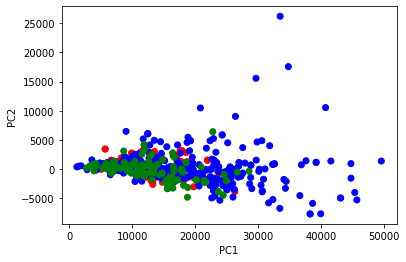

In [20]:
# Rotating the data
rotated_data = rotate_data(M, eig_v)

# Coloring by artist
colors = ['red', 'blue', 'green']
c      = [colors[i] for i, u_artist in enumerate(df.artist.unique()) for artist in df.artist if u_artist == artist]

# Scatter plot
plt.scatter(rotated_data[0], rotated_data[1], c=c)

# Setting axes
plt.xlabel('PC1')
plt.ylabel('PC2')

### Part E: Inspect Results

You should notice that one artist seems to be responsible for most of the outlying songs in the principal component directions.

Ei) Let's create a very lazy measure for outlierness and say that any song that has a **sum** of PC1 and PC2 values exceeding 100 is an "outlier," of which there should be 4 songs.  Which songs are they?

Eii) What lyrics seem to be most responsible for the spread of the data in the reduced dimensions?  In other words: in these 4 songs what words were most common, and how often did they occur? Print out the word frequencies in the original data frame for any words that appeared 25 or more times in the 4 "outlier" songs.

Eiii) More importantly: is there anything else we could or should have done when processing the songs to possibly prevent this?

In [21]:
print(rotated_data)
print(np.min(np.sum(rotated_data)), np.max(np.sum(rotated_data)))

                0            1
0    17700.894339  -250.695398
1    23814.353023  -660.219398
2    18719.950584 -1459.155437
3    24629.286835 -2794.963576
4    10545.788680  1516.413313
..            ...          ...
543   5827.557997   966.073328
544  13400.642667  -588.298730
545  11383.664787  -515.998238
546   7471.644210   189.833804
547  11518.263215  -193.468883

[548 rows x 2 columns]
112194.07625018674 9066739.736416673


**Solution Markdown**: 


Again, asked a question about this two days ago, and still no answer. Without attempting to normalize $ME$, I have every song as an outlier. When I try to normalize, no songs are outliers. I'm 90% sure I did what was in the slides, so who knows anymore.

### Part F: The last homework problem of the class

Take the original data
Consider the song in index 501 of the original data frame.  What song is it?  How strong was it in the concept space in the 2-dimensional representation of the data?  Does it appear exceptional in any way?  Repeat your plot from part C with song \#501 in its own color, with a label.

The name of song #501 is: never gonna give you up by rick-astley

Strength of song #501 is:
0    16462.676174
1    -2055.828481
Name: 501, dtype: float64


Text(16462.676173645345, -2055.8284807987125, 'never gonna give you up')

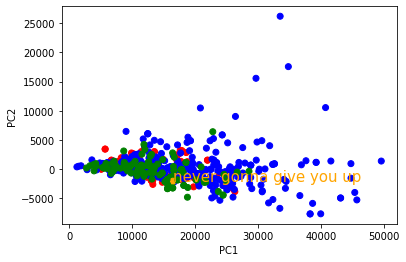

In [22]:
# Finding the song at the given index
index     = 501
loc       = df.loc[index]
song_name = loc.filtered_song_name
artist    = loc.artist
print(f'The name of song #{index} is: {song_name} by {artist}\n')

# Seeing how strong the song is in the concept space of the 2-D representation
print(f'Strength of song #{index} is:\n{rotated_data.T[index]}')

# Coloring by artist
colors   = ['red', 'blue', 'green', 'orange']
c        = [colors[i] for i, u_artist in enumerate(df.artist.unique()) for artist in df.artist if u_artist == artist]
c[index] = colors[-1]
# Scatter plot
plt.scatter(rotated_data[0], rotated_data[1], c=c)

# Setting axes
plt.xlabel('PC1')
plt.ylabel('PC2')

# Labelling our point
label = f'{song_name}'
x     = rotated_data.T[index][0]
y     = rotated_data.T[index][1]
plt.annotate(label, (x, y), fontsize=15, color=colors[-1])

*Never gonna give you up* looks incredibly strong in the concept space, but since I had trouble a few questions ago, this doesn't seem to make sense (as I expected it to be an outlier) and I don't know. With the compounding effect these questions have, it's incredibly difficult to do well on remaining parts when there's still confusion on the previous parts.